In [1]:
import os
import numpy as np 
import pandas as pd 

from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC, SVC
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.metrics import confusion_matrix, f1_score, precision_score, roc_auc_score

import numpy as np
import pandas as pd
import os
from typing import List, Tuple
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import svm
from sklearn.pipeline import FeatureUnion, Pipeline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [2]:
path = "hsd/Reddit/"
df_train = pd.read_csv(os.path.join(path, "train.csv"))
df_test = pd.read_csv(os.path.join(path, 'test.csv'))
df_sub = pd.read_csv(os.path.join(path, 'validate.csv'))

In [3]:
df_train_hate = df_train[df_train['class'] == 1]
df_train_no_hate = df_train[df_train['class'] == 2]

<AxesSubplot:ylabel='Frequency'>

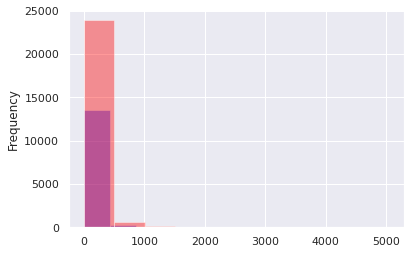

In [4]:
df_train_hate.lemmatized_text.apply(lambda x: len(str(x))).plot.hist(alpha=0.4, color="blue")
df_train_no_hate.lemmatized_text.apply(lambda x: len(str(x))).plot.hist(alpha=0.4, color="red")

<AxesSubplot:ylabel='Frequency'>

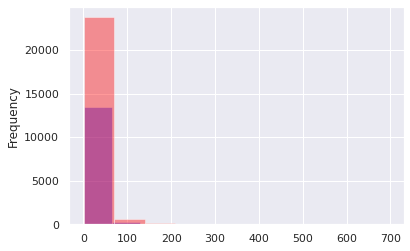

In [5]:
df_train_hate.lemmatized_text.apply(lambda x: len(str(x).split(" "))).plot.hist(alpha=0.4, color="blue")
df_train_no_hate.lemmatized_text.apply(lambda x: len(str(x).split(" "))).plot.hist(alpha=0.4, color="red")

In [6]:
cv = CountVectorizer()
cv.fit(df_train_hate.lemmatized_text.apply(lambda x: str(x)))
cv.fit(df_train_no_hate.lemmatized_text.apply(lambda x: str(x)))


cv_fit_t = cv.transform(df_train_hate.lemmatized_text.apply(lambda x: str(x)))
top_words = {name: occurence for name, occurence in zip(cv.get_feature_names(), cv_fit_t.toarray().sum(axis=0))}
cv_fit_f = cv.transform(df_train_no_hate.lemmatized_text.apply(lambda x: str(x)))



data = {'feature': cv.get_feature_names(), 
        'true': cv_fit_t.toarray().sum(axis=0), 
        "false":  cv_fit_f.toarray().sum(axis=0)}

df_words = pd.DataFrame(data=data)
df_words.set_index(['feature'])

,true,false
feature,,
aa,2,2
aaa,1,7
aaaa,0,1
aaaaaaaaaaaaaaaaaaaaaaaaaaaa,0,1
aaaaaaaaaaaand,0,1
...,...,...
zulu,2,1
zwaarder,0,1
zyclon,1,1


In [7]:
df_words.sort_values(by="false", ascending=True).head(100)

,feature,true,false
28038,zzzzzzz,0,1
9314,fns,0,1
19126,ppuppy,0,1
19124,pplz,0,1
9318,foar,0,1
...,...,...,...
19082,potiphar,0,1
9365,fondling,1,1
19081,potion,0,1
19080,potholes,0,1


In [8]:
classifier = svm.LinearSVC(C=1.0, class_weight="balanced")
model = Pipeline(
    [
        ("vectorizer", TfidfVectorizer()),
        ("classifier", classifier),
    ]
)

In [9]:
model.fit(df_train.lemmatized_text.apply(lambda x: str(x)), df_train['class'])
prediction = model.predict(df_test.lemmatized_text.apply(lambda x: str(x)))

In [10]:
print(metrics.accuracy_score(df_test['class'], prediction))
print(metrics.precision_score(df_test['class'], prediction))
print(metrics.f1_score(df_test['class'], prediction))

0.9028415961305924
0.8790730092350584
0.8626143455586902


In [11]:
print(model.named_steps["vectorizer"])

TfidfVectorizer()


In [12]:
# Get the names of each feature
feature_names = model.named_steps["vectorizer"].get_feature_names()

# Get the coefficients of each feature
coefs = model.named_steps["classifier"].coef_.flatten()

In [13]:
# Visualize feature importances
# Sort features by absolute value
df = pd.DataFrame(zip(feature_names, coefs), columns=["feature", "value"])
df["abs_value"] = df["value"].apply(lambda x: abs(x))
df["colors"] = df["value"].apply(lambda x: "green" if x > 0 else "red")
df = df.sort_values("abs_value", ascending=False)

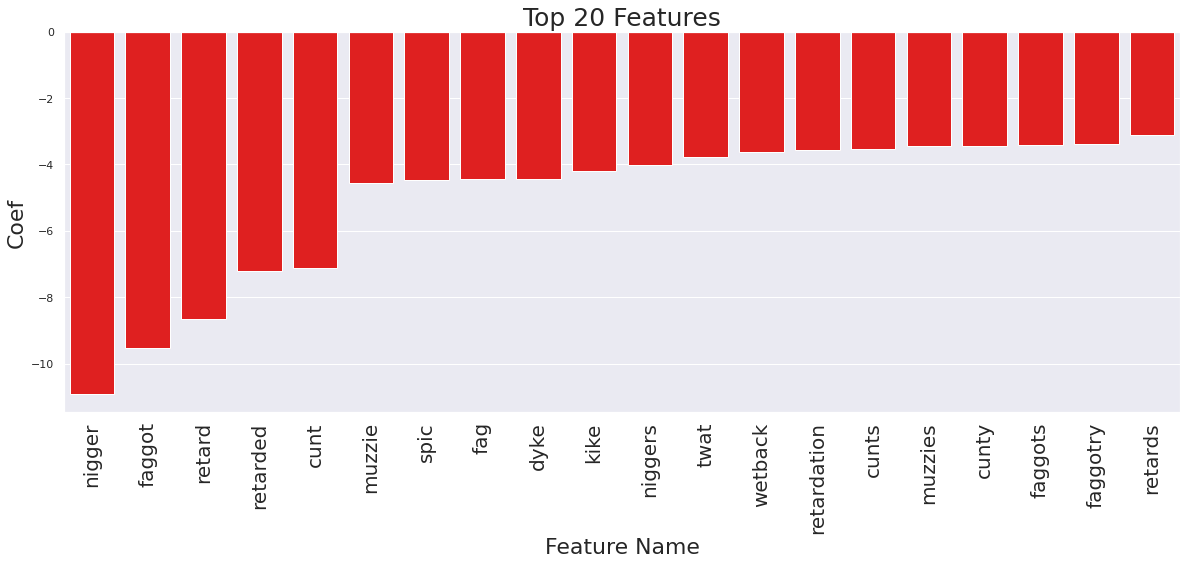

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(20, 7))
sns.barplot(x="feature",
            y="value",
            data=df.head(20),
           palette=df.head(20)["colors"])
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontsize=20)
ax.set_title("Top 20 Features", fontsize=25)
ax.set_ylabel("Coef", fontsize=22)
ax.set_xlabel("Feature Name", fontsize=22)
plt.savefig('results/gab_features.png')

In [15]:
def confusion_matrix_plot(conf_mat, cls, x_label, y_label, title, file_name=None):
    plt.imshow(conf_mat, interpolation='nearest', cmap=plt.cm.Wistia)
    plt.title(title)
    plt.ylabel(y_label)
    plt.xlabel(x_label)
    tick_marks = np.arange(len(cls))
    plt.grid(False)
    plt.xticks(tick_marks, cls, rotation=45)
    plt.yticks(tick_marks, cls)
    
    for i in range(len(cls)):
        for j in range(len(cls)):
            plt.text(j - 0.2, i, str(conf_mat[i][j]), fontsize=16)
    
    if file_name:
        plt.savefig(file_name)
    plt.show()

In [16]:
classes = ['hate speech', 'no hate']

In [17]:
import csv
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

y_true = np.array(df_test['class'].tolist())
y_pred = prediction

conf_mat = confusion_matrix(y_true, y_pred)
roc = roc_auc_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)

acc = float(np.sum(np.diag(conf_mat)))/np.sum(np.sum(conf_mat))
f1s0 = 2*float(conf_mat[0][0])/(2*float(conf_mat[0][0]) + conf_mat[0][1] + conf_mat[1][0])
f1s1 = 2*float(conf_mat[1][1])/(2*float(conf_mat[1][1]) + conf_mat[1][0] + conf_mat[0][1])

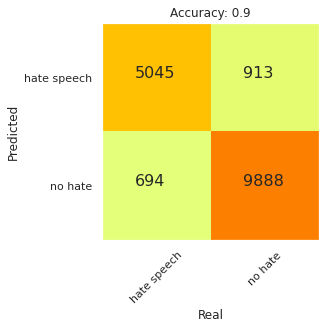

In [18]:
confusion_matrix_plot(conf_mat, cls=classes,
                      x_label='Real', y_label='Predicted',
                      title='Accuracy: {}'.format(round(acc, 2)),
                      file_name='results/en_conv/cm.png')

In [19]:
if not os.path.exists('results/en_svm/short_results.csv'):
    with open('results/en_svm/short_results.csv', 'w') as f:
        writer = csv.writer(f)
        writer.writerow(['Accuracy', 'F1 score (0)', 'F1 score (1)', 'F1', 'ROC', 'Precision'])
        writer.writerow([acc, f1s0, f1s1, f1, roc, precision])
else:
    with open('results/en_svm/short_results.csv', 'a') as f:
        writer = csv.writer(f)
        writer.writerow([acc, f1s0, f1s1, f1, roc, precision])